In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
# import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
# import json
import geopy.distance
import numpy as np
# import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
# import tabula
# import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Load neighbourhood crime rates and rental costs
- about https://data.torontopolice.on.ca/datasets/TorontoPS::neighbourhood-crime-rates-2020-1/about 
- Neighbourhood GeoJSON file https://opendata.arcgis.com/api/v3/datasets/3a1a9c98146e470e94e814b0e3a3fbca_0/downloads/data?format=geojson&spatialRefId=4326
- *Population figures reflect only the resident population of a region. The temporary population such as the commuters and business patrons are not included.

In [8]:
neighbourhoods = gpd.read_file('../data/raw/Neighbourhood_Boundary.geojson')
neighbourhoods.HOOD_ID = neighbourhoods.HOOD_ID.astype(int).astype(str)
neighbourhoods.head()

,OBJECTID,NEIGHBOURHOOD_158,HOOD_ID,POPN_PROJ_2022,ASSAULT_2014,ASSAULT_2015,ASSAULT_2016,ASSAULT_2017,ASSAULT_2018,ASSAULT_2019,ASSAULT_2020,ASSAULT_2021,ASSAULT_2022,ASSAULT_RATE_2014,ASSAULT_RATE_2015,ASSAULT_RATE_2016,ASSAULT_RATE_2017,ASSAULT_RATE_2018,ASSAULT_RATE_2019,ASSAULT_RATE_2020,ASSAULT_RATE_2021,ASSAULT_RATE_2022,AUTOTHEFT_2014,AUTOTHEFT_2015,AUTOTHEFT_2016,AUTOTHEFT_2017,AUTOTHEFT_2018,AUTOTHEFT_2019,AUTOTHEFT_2020,AUTOTHEFT_2021,AUTOTHEFT_2022,AUTOTHEFT_RATE_2014,AUTOTHEFT_RATE_2015,AUTOTHEFT_RATE_2016,AUTOTHEFT_RATE_2017,AUTOTHEFT_RATE_2018,AUTOTHEFT_RATE_2019,AUTOTHEFT_RATE_2020,AUTOTHEFT_RATE_2021,AUTOTHEFT_RATE_2022,BIKETHEFT_2014,BIKETHEFT_2015,BIKETHEFT_2016,BIKETHEFT_2017,BIKETHEFT_2018,BIKETHEFT_2019,BIKETHEFT_2020,BIKETHEFT_2021,BIKETHEFT_2022,BIKETHEFT_RATE_2014,BIKETHEFT_RATE_2015,BIKETHEFT_RATE_2016,BIKETHEFT_RATE_2017,BIKETHEFT_RATE_2018,BIKETHEFT_RATE_2019,BIKETHEFT_RATE_2020,BIKETHEFT_RATE_2021,BIKETHEFT_RATE_2022,BREAKENTER_2014,BREAKENTER_2015,BREAKENTER_2016,BREAKENTER_2017,BREAKENTER_2018,BREAKENTER_2019,BREAKENTER_2020,BREAKENTER_2021,BREAKENTER_2022,BREAKENTER_RATE_2014,BREAKENTER_RATE_2015,BREAKENTER_RATE_2016,BREAKENTER_RATE_2017,BREAKENTER_RATE_2018,BREAKENTER_RATE_2019,BREAKENTER_RATE_2020,BREAKENTER_RATE_2021,BREAKENTER_RATE_2022,HOMICIDE_2014,HOMICIDE_2015,HOMICIDE_2016,HOMICIDE_2017,HOMICIDE_2018,HOMICIDE_2019,HOMICIDE_2020,HOMICIDE_2021,HOMICIDE_2022,HOMICIDE_RATE_2014,HOMICIDE_RATE_2015,HOMICIDE_RATE_2016,HOMICIDE_RATE_2017,HOMICIDE_RATE_2018,HOMICIDE_RATE_2019,HOMICIDE_RATE_2020,HOMICIDE_RATE_2021,HOMICIDE_RATE_2022,ROBBERY_2014,ROBBERY_2015,ROBBERY_2016,ROBBERY_2017,ROBBERY_2018,ROBBERY_2019,ROBBERY_2020,ROBBERY_2021,ROBBERY_2022,ROBBERY_RATE_2014,ROBBERY_RATE_2015,ROBBERY_RATE_2016,ROBBERY_RATE_2017,ROBBERY_RATE_2018,ROBBERY_RATE_2019,ROBBERY_RATE_2020,ROBBERY_RATE_2021,ROBBERY_RATE_2022,SHOOTING_2014,SHOOTING_2015,SHOOTING_2016,SHOOTING_2017,SHOOTING_2018,SHOOTING_2019,SHOOTING_2020,SHOOTING_2021,SHOOTING_2022,SHOOTING_RATE_2014,SHOOTING_RATE_2015,SHOOTING_RATE_2016,SHOOTING_RATE_2017,SHOOTING_RATE_2018,SHOOTING_RATE_2019,SHOOTING_RATE_2020,SHOOTING_RATE_2021,SHOOTING_RATE_2022,THEFTFROMMV_2014,THEFTFROMMV_2015,THEFTFROMMV_2016,THEFTFROMMV_2017,THEFTFROMMV_2018,THEFTFROMMV_2019,THEFTFROMMV_2020,THEFTFROMMV_2021,THEFTFROMMV_2022,THEFTFROMMV_RATE_2014,THEFTFROMMV_RATE_2015,THEFTFROMMV_RATE_2016,THEFTFROMMV_RATE_2017,THEFTFROMMV_RATE_2018,THEFTFROMMV_RATE_2019,THEFTFROMMV_RATE_2020,THEFTFROMMV_RATE_2021,THEFTFROMMV_RATE_2022,THEFTOVER_2014,THEFTOVER_2015,THEFTOVER_2016,THEFTOVER_2017,THEFTOVER_2018,THEFTOVER_2019,THEFTOVER_2020,THEFTOVER_2021,THEFTOVER_2022,THEFTOVER_RATE_2014,THEFTOVER_RATE_2015,THEFTOVER_RATE_2016,THEFTOVER_RATE_2017,THEFTOVER_RATE_2018,THEFTOVER_RATE_2019,THEFTOVER_RATE_2020,THEFTOVER_RATE_2021,THEFTOVER_RATE_2022,Shape__Area,Shape__Length,geometry
0,1,South Eglinton-Davisville,174,21418,63,61,70,82,85,70,82,121,129,344.978607,332.135498,377.826996,429.454315,431.581604,345.866913,396.844604,577.455383,602.297119,5,4,3,9,15,8,15,15,11,27.379259,21.779381,16.192579,47.135231,76.161461,39.527649,72.593521,71.585381,71.585381,17,19,27,34,30,42,94,34,18,93.089478,103.452003,145.733307,178.066406,152.322906,207.520096,454.919403,162.260193,162.260193,27,32,25,37,48,83,70,44,26,147.848007,174.235001,134.938202,193.778198,243.716705,410.099304,338.769806,209.983795,121.393204,0,0,1,0,0,1,1,1,0,0.000000,0,5,0,0.000000,4.940956,4.839568,4.772358,0.000000,12,10,9,7,17,5,16,11,16,65.710220,48.577751,36.660728,86.316322,24.704781,77.433090,52.495941,74.703522,54.448441,1,0,1,0,1,1,1,0,1,5.475852,0.000000,5.397528,0.000000,5.077431,4.940956,4.839568,0.000000,4.668970,18,19,13,17,19,24,43,22,18,98.565331,103.452003,70.167862,89.033203,96.471184,118.582901,208.101395,104.991898,84.041458,4,3,4,1,3,3,5,6,3,21.90341,16.334530,21.590111,5.237247,15.232290,14.822870,24.197840,28.634150,14.006910,9.443091e+05,4005.550293,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ..."
1,2,Nor

In [9]:
# number of neighbourhoods
len(neighbourhoods.HOOD_ID.unique())

158

In [10]:
# remove leading zeros in HOOD_ID
neighbourhoods['HOOD_ID'] = neighbourhoods['HOOD_ID'].str.lstrip('0')

<Axes: >

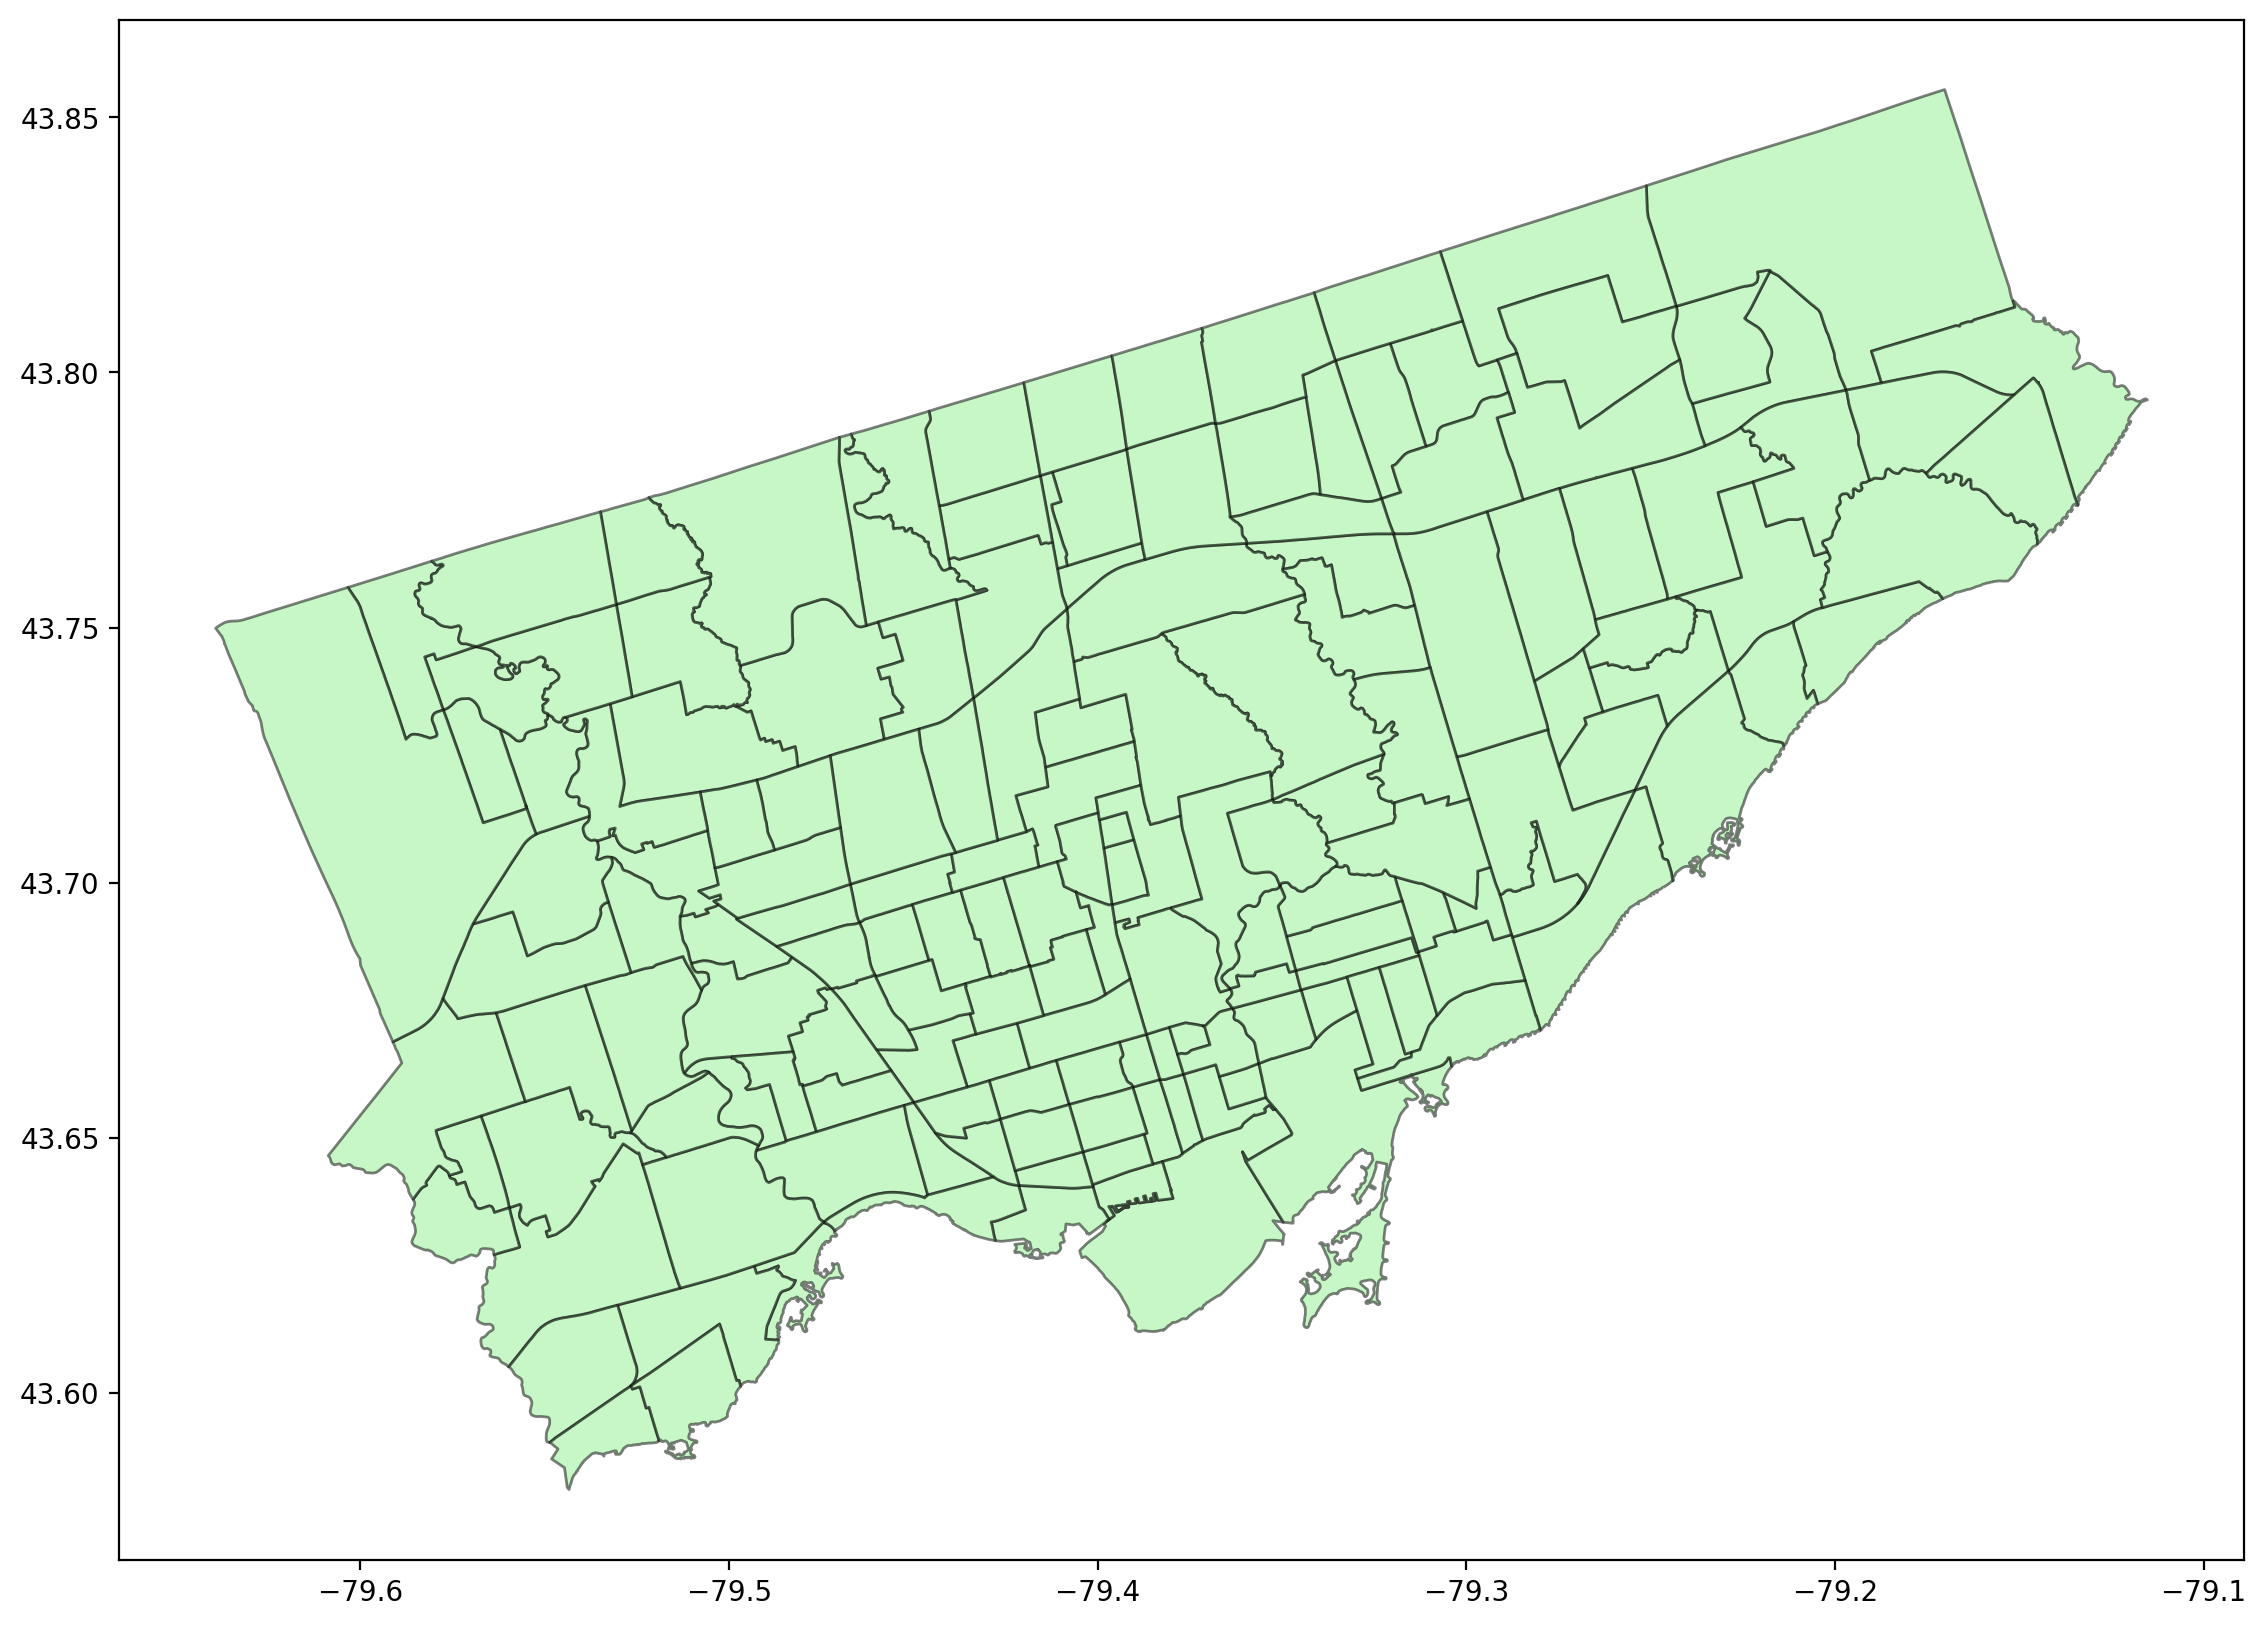

In [11]:
neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)

## Mapping between MLS municipality and neighbourhood

While we have the boundary files for neighbourhood, the apartment rental data from TRREB are only availble to the level of municipalities defined by MLS. Therefore we need to link the two together.

In [12]:
# get mapping between neighbourhood and MLS municipalities
r = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto#Multiple_listing_service_districts_and_neighbourhoods')
soup = BeautifulSoup(r.text)
table = soup.find('table', {'class' : 'wikitable sortable'})
df = pd.read_html(str(table))[0]

district_neighbourhood = {}

for key, value in df.set_index('District Number').to_dict()['Neighbourhoods Included'].items():
    for x in value.split(','):
        district_neighbourhood[x.strip()] = key
        
district_neighbourhood

{'Downtown': 'C01',
 'Harbourfront': 'C01',
 'Little Italy': 'C01',
 'Little Portugal': 'C01',
 'Dufferin Grove': 'C01',
 'Palmerston': 'C01',
 'University': 'C01',
 'Bay Street Corridor': 'C01',
 'Kensington Market': 'C01',
 'Chinatown': 'C01',
 'Trinity Bellwoods': 'C01',
 'South Niagara': 'C01',
 'Island airport': 'C01',
 'The Islands': 'C01',
 'Waterfront communities C1': 'C01',
 "Queen's Park": 'C01',
 'Ontario Provincial Government': 'C01',
 'Victoria Hotel': 'C01',
 'Central Bay Street': 'C01',
 'First Canadian Place': 'C01',
 'Design Exchange': 'C01',
 'Adelaide': 'C01',
 'Union Station': 'C01',
 'The Annex': 'C02',
 'Yorkville': 'C02',
 'South Hill': 'C02',
 'Summerhill': 'C02',
 'Wychwood Park': 'C02',
 'Deer Park': 'C02',
 'Casa Loma': 'C02',
 'Forest Hill South': 'C03',
 'Oakwood–Vaughan': 'C03',
 'Humewood–Cedarvale': 'C03',
 'Corso Italia': 'W03',
 'Forest Hill Road Park': 'C03',
 'Bedford Park': 'C04',
 'Lawrence Manor': 'C04',
 'North Toronto': 'C04',
 'Forest Hill Nort

In [13]:
neighbourhoods['district'] = neighbourhoods.apply(
    lambda x: district_neighbourhood.get(x['NEIGHBOURHOOD_158'], np.nan), axis = 1).fillna("NA")

In [15]:
# use plotly to check which neighbourhood does not have a corresponding district code
# fig = px.choropleth(neighbourhoods,
#               geojson=neighbourhoods.geometry,
#               locations=neighbourhoods.index,
#               color = 'district',
#               hover_data=['Neighbourhood', "hood_id"])
# fig.update_geos(fitbounds="locations", visible=False)

In [67]:
# resource from Toronto MLS
# https://www.torontomls.net/Communities/map.html
my_map = {
    'C01': ['81','82','80','78','77', '162', '163', '164', '165', '166', '169', '170'], 
    'C02': ['95','94','97'],
    'C03': ['106', '107','100'], 'C04': ['102', '32', '39','105','103'],
    'C07': ['35'], 'C08': ['75','74','71', '167', '168'], 'C09': ['98'], 'C10': ['104','99', '174'],
    'C11': ['56'], 'C12': ['41','40'], 'C13': ['42','45', '149', '150'],
    'C14': ['151', '152', '153'],
    'E01': ['68','70','65'], 'E02': ['62'], 'E03': ['67','57','58','59','66','60','54','61'],
    'E04': ['120','124','119'], 'E05': ['118', '148'], 'E06': ['121','122'], 'E07': ['128', '129'],
    'E08': ['138'], 'E09': ['127', '141', '142', '156', '157'], 'E10': ['133', '143'],
    'E11': ['144', '146'],
    'W01': ['87'], 'W02': ['93','90','89','114', '171'], 'W03': ['91', '92','109','110','111'], 
    'W04': ['112','30','23','31','108'], 'W05': ['23','22','25','24', '154'], 'W06': ['17', '160'],
    'W07': ['16'], 'W08': ['14','15','13','11', '158', '159'], 'W09':['7','8'],
    'W10': ['1','2','3','4','5']
}

In [68]:
district_hoodID = {}
for key, value in my_map.items():
    for x in value:
        district_hoodID[x] = key
district_hoodID

{'81': 'C01',
 '82': 'C01',
 '80': 'C01',
 '78': 'C01',
 '77': 'C01',
 '162': 'C01',
 '163': 'C01',
 '164': 'C01',
 '165': 'C01',
 '166': 'C01',
 '169': 'C01',
 '170': 'C01',
 '95': 'C02',
 '94': 'C02',
 '97': 'C02',
 '106': 'C03',
 '107': 'C03',
 '100': 'C03',
 '102': 'C04',
 '32': 'C04',
 '39': 'C04',
 '105': 'C04',
 '103': 'C04',
 '35': 'C07',
 '75': 'C08',
 '74': 'C08',
 '71': 'C08',
 '167': 'C08',
 '168': 'C08',
 '98': 'C09',
 '104': 'C10',
 '99': 'C10',
 '174': 'C10',
 '56': 'C11',
 '41': 'C12',
 '40': 'C12',
 '42': 'C13',
 '45': 'C13',
 '149': 'C13',
 '150': 'C13',
 '151': 'C14',
 '152': 'C14',
 '153': 'C14',
 '68': 'E01',
 '70': 'E01',
 '65': 'E01',
 '62': 'E02',
 '67': 'E03',
 '57': 'E03',
 '58': 'E03',
 '59': 'E03',
 '66': 'E03',
 '60': 'E03',
 '54': 'E03',
 '61': 'E03',
 '120': 'E04',
 '124': 'E04',
 '119': 'E04',
 '118': 'E05',
 '148': 'E05',
 '121': 'E06',
 '122': 'E06',
 '128': 'E07',
 '129': 'E07',
 '138': 'E08',
 '127': 'E09',
 '141': 'E09',
 '142': 'E09',
 '156': 'E09'

In [69]:
neighbourhoods['district'] = neighbourhoods.apply(lambda x: district_hoodID.get(x['HOOD_ID'], x['district']) , axis = 1)

C:\Users\willi\AppData\Local\Temp\ipykernel_37168\3263622915.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_big = mpl.cm.get_cmap('Pastel1', 35)


Text(0.5, 1.0, 'MLS districts in Toronto containing neighbourhoods')

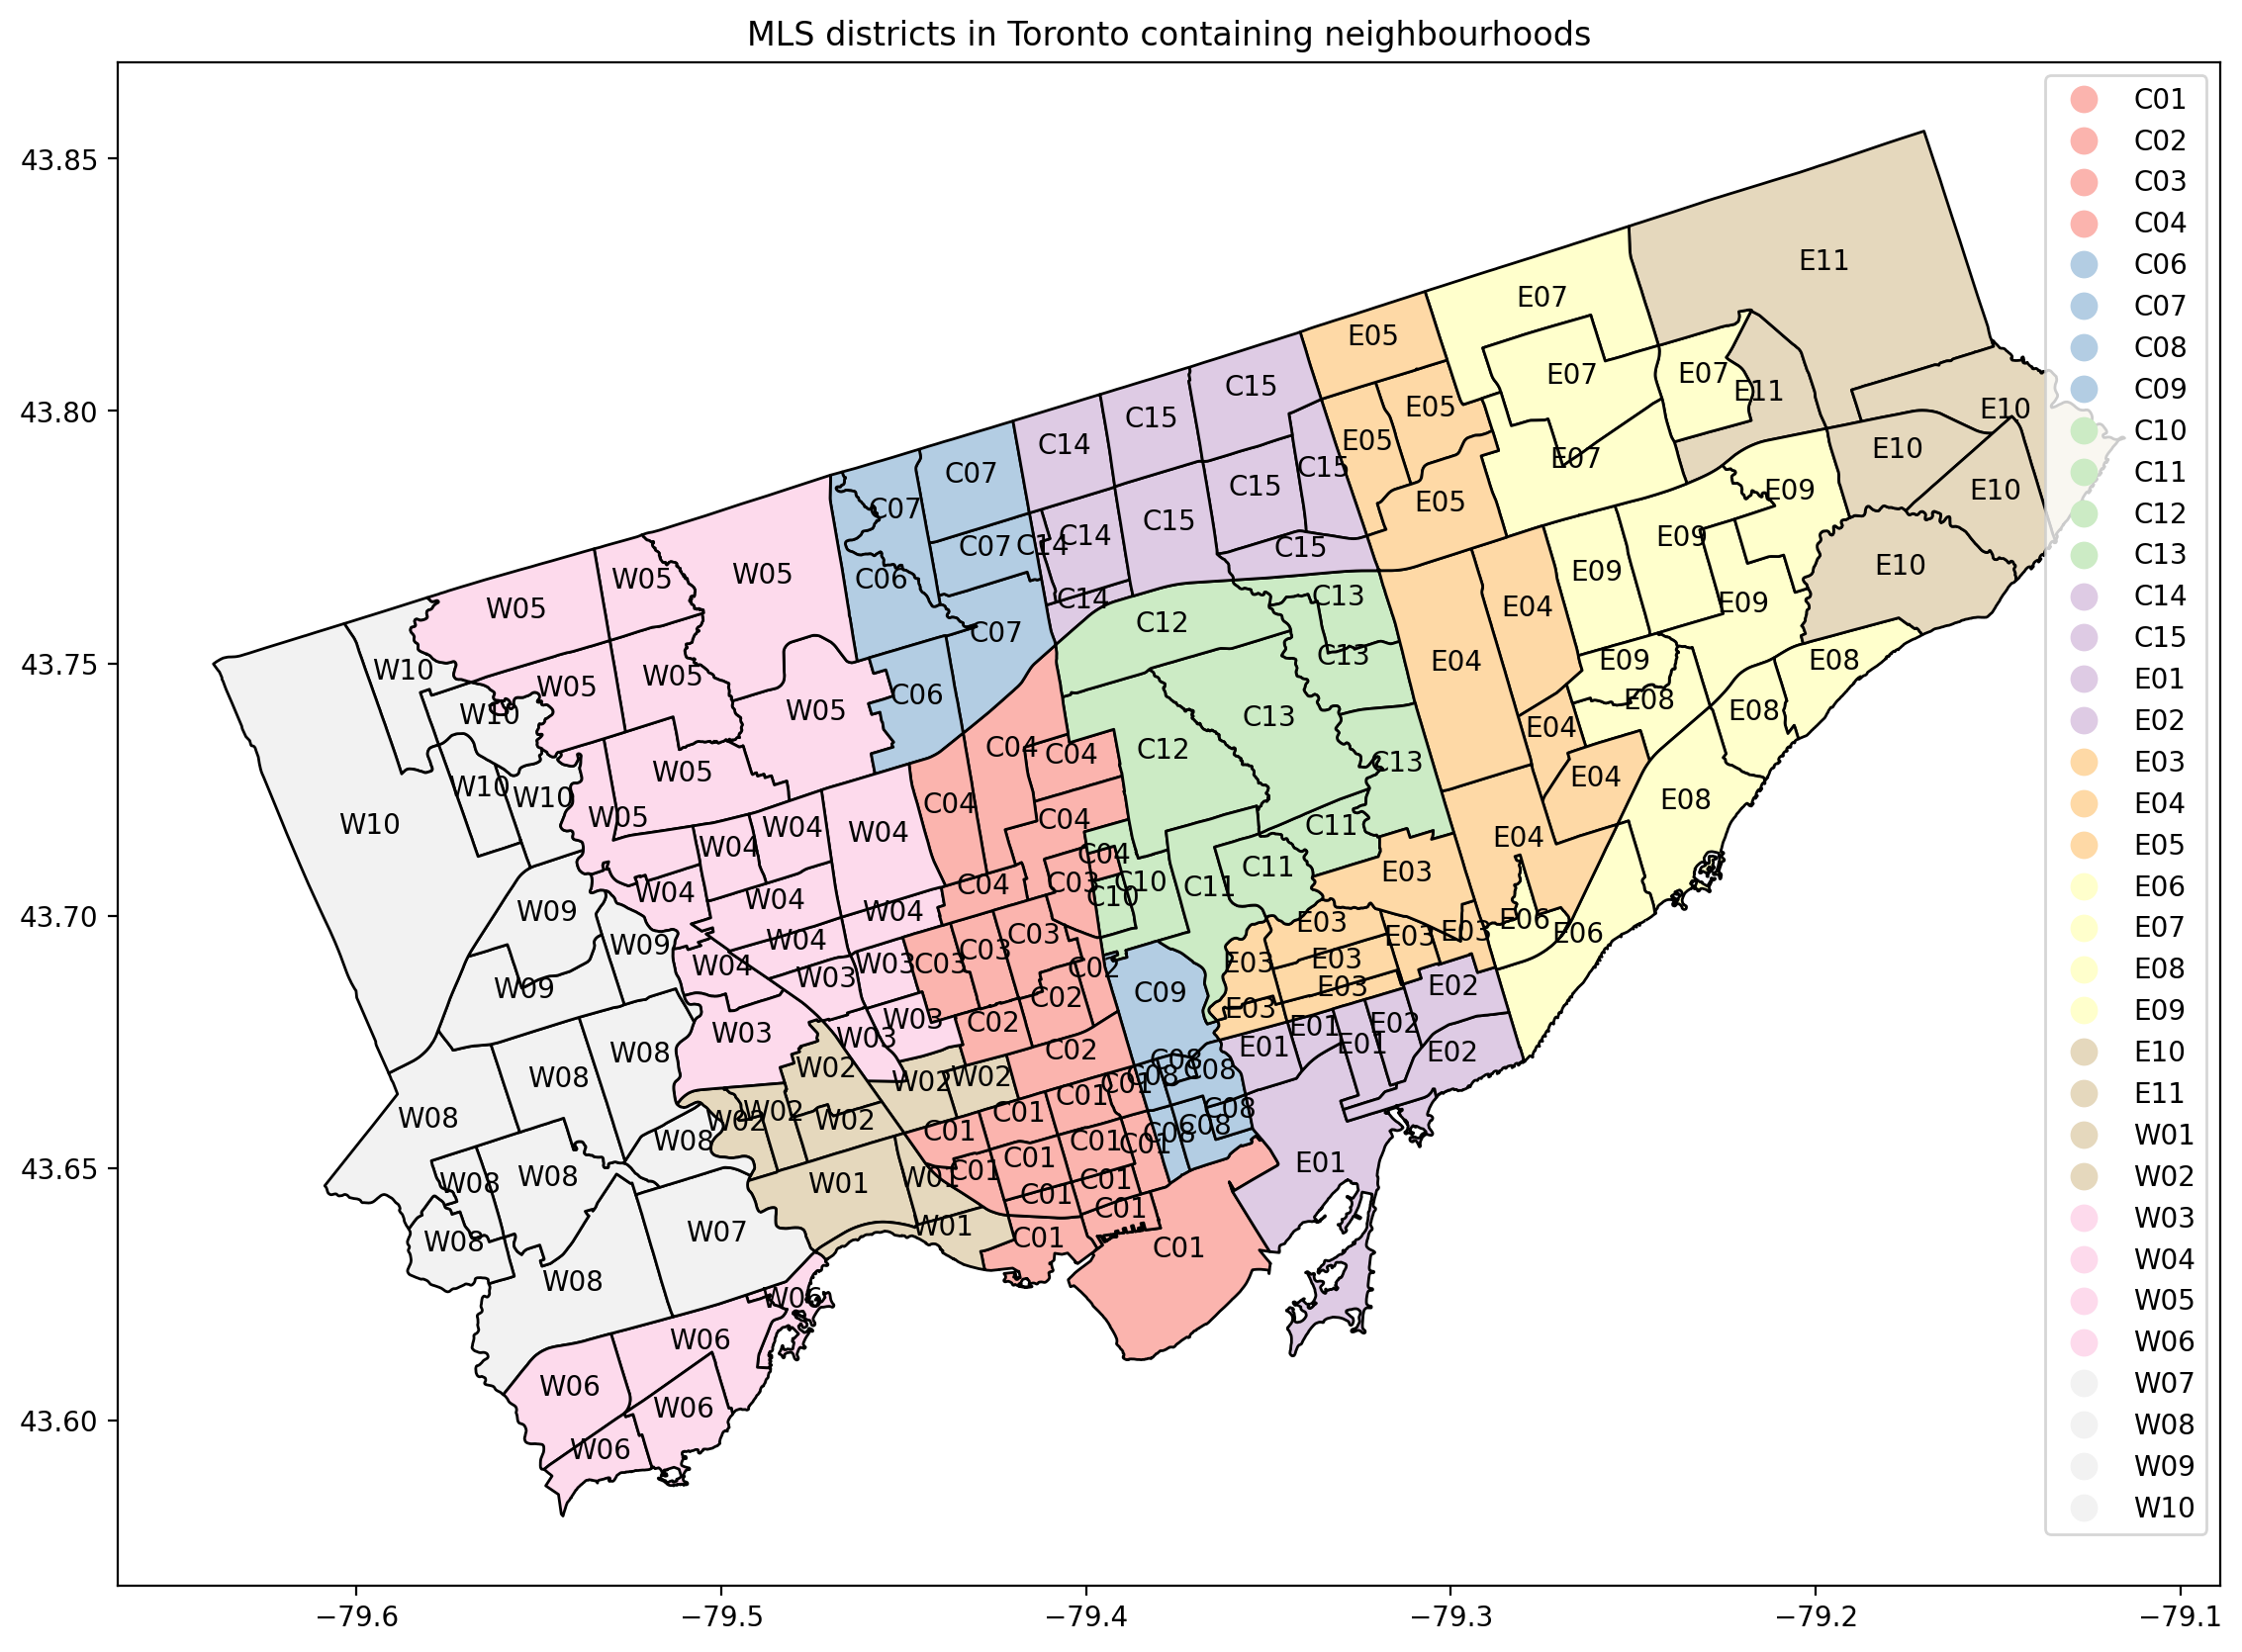

In [70]:
# now we have the complete mapping, with each MLS municipality containing a number of neighbourhoods
cmap_big = mpl.cm.get_cmap('Pastel1', 35)
newcmp = mpl.colors.ListedColormap(cmap_big(np.linspace(0, 1, 35)))

ax = neighbourhoods.plot(column = 'district',
                   legend = True,
                   cmap = newcmp,
                   edgecolor = 'black')

for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.district):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')

ax.set_title('MLS districts in Toronto containing neighbourhoods')

In [71]:
neighbourhoods

,OBJECTID,NEIGHBOURHOOD_158,HOOD_ID,POPN_PROJ_2022,ASSAULT_2014,ASSAULT_2015,ASSAULT_2016,ASSAULT_2017,ASSAULT_2018,ASSAULT_2019,ASSAULT_2020,ASSAULT_2021,ASSAULT_2022,ASSAULT_RATE_2014,ASSAULT_RATE_2015,ASSAULT_RATE_2016,ASSAULT_RATE_2017,ASSAULT_RATE_2018,ASSAULT_RATE_2019,ASSAULT_RATE_2020,ASSAULT_RATE_2021,ASSAULT_RATE_2022,AUTOTHEFT_2014,AUTOTHEFT_2015,AUTOTHEFT_2016,AUTOTHEFT_2017,AUTOTHEFT_2018,AUTOTHEFT_2019,AUTOTHEFT_2020,AUTOTHEFT_2021,AUTOTHEFT_2022,AUTOTHEFT_RATE_2014,AUTOTHEFT_RATE_2015,AUTOTHEFT_RATE_2016,AUTOTHEFT_RATE_2017,AUTOTHEFT_RATE_2018,AUTOTHEFT_RATE_2019,AUTOTHEFT_RATE_2020,AUTOTHEFT_RATE_2021,AUTOTHEFT_RATE_2022,BIKETHEFT_2014,BIKETHEFT_2015,BIKETHEFT_2016,BIKETHEFT_2017,BIKETHEFT_2018,BIKETHEFT_2019,BIKETHEFT_2020,BIKETHEFT_2021,BIKETHEFT_2022,BIKETHEFT_RATE_2014,BIKETHEFT_RATE_2015,BIKETHEFT_RATE_2016,BIKETHEFT_RATE_2017,BIKETHEFT_RATE_2018,BIKETHEFT_RATE_2019,BIKETHEFT_RATE_2020,BIKETHEFT_RATE_2021,BIKETHEFT_RATE_2022,BREAKENTER_2014,BREAKENTER_2015,BREAKENTER_2016,BREAKENTER_2017,BREAKENTER_2018,BREAKENTER_2019,BREAKENTER_2020,BREAKENTER_2021,BREAKENTER_2022,BREAKENTER_RATE_2014,BREAKENTER_RATE_2015,BREAKENTER_RATE_2016,BREAKENTER_RATE_2017,BREAKENTER_RATE_2018,BREAKENTER_RATE_2019,BREAKENTER_RATE_2020,BREAKENTER_RATE_2021,BREAKENTER_RATE_2022,HOMICIDE_2014,HOMICIDE_2015,HOMICIDE_2016,HOMICIDE_2017,HOMICIDE_2018,HOMICIDE_2019,HOMICIDE_2020,HOMICIDE_2021,HOMICIDE_2022,HOMICIDE_RATE_2014,HOMICIDE_RATE_2015,HOMICIDE_RATE_2016,HOMICIDE_RATE_2017,HOMICIDE_RATE_2018,HOMICIDE_RATE_2019,HOMICIDE_RATE_2020,HOMICIDE_RATE_2021,HOMICIDE_RATE_2022,ROBBERY_2014,ROBBERY_2015,ROBBERY_2016,ROBBERY_2017,ROBBERY_2018,ROBBERY_2019,ROBBERY_2020,ROBBERY_2021,ROBBERY_2022,ROBBERY_RATE_2014,ROBBERY_RATE_2015,ROBBERY_RATE_2016,ROBBERY_RATE_2017,ROBBERY_RATE_2018,ROBBERY_RATE_2019,ROBBERY_RATE_2020,ROBBERY_RATE_2021,ROBBERY_RATE_2022,SHOOTING_2014,SHOOTING_2015,SHOOTING_2016,SHOOTING_2017,SHOOTING_2018,SHOOTING_2019,SHOOTING_2020,SHOOTING_2021,SHOOTING_2022,SHOOTING_RATE_2014,SHOOTING_RATE_2015,SHOOTING_RATE_2016,SHOOTING_RATE_2017,SHOOTING_RATE_2018,SHOOTING_RATE_2019,SHOOTING_RATE_2020,SHOOTING_RATE_2021,SHOOTING_RATE_2022,THEFTFROMMV_2014,THEFTFROMMV_2015,THEFTFROMMV_2016,THEFTFROMMV_2017,THEFTFROMMV_2018,THEFTFROMMV_2019,THEFTFROMMV_2020,THEFTFROMMV_2021,THEFTFROMMV_2022,THEFTFROMMV_RATE_2014,THEFTFROMMV_RATE_2015,THEFTFROMMV_RATE_2016,THEFTFROMMV_RATE_2017,THEFTFROMMV_RATE_2018,THEFTFROMMV_RATE_2019,THEFTFROMMV_RATE_2020,THEFTFROMMV_RATE_2021,THEFTFROMMV_RATE_2022,THEFTOVER_2014,THEFTOVER_2015,THEFTOVER_2016,THEFTOVER_2017,THEFTOVER_2018,THEFTOVER_2019,THEFTOVER_2020,THEFTOVER_2021,THEFTOVER_2022,THEFTOVER_RATE_2014,THEFTOVER_RATE_2015,THEFTOVER_RATE_2016,THEFTOVER_RATE_2017,THEFTOVER_RATE_2018,THEFTOVER_RATE_2019,THEFTOVER_RATE_2020,THEFTOVER_RATE_2021,THEFTOVER_RATE_2022,Shape__Area,Shape__Length,geometry,district
0,1,South Eglinton-Davisville,174,21418,63,61,70,82,85,70,82,121,129,344.978607,332.135498,377.826996,429.454315,431.581604,345.866913,396.844604,577.455383,602.297119,5,4,3,9,15,8,15,15,11,27.379259,21.779381,16.192579,47.135231,76.161461,39.527649,72.593521,71.585381,71.585381,17,19,27,34,30,42,94,34,18,93.089478,103.452003,145.733307,178.066406,152.322906,207.520096,454.919403,162.260193,162.260193,27,32,25,37,48,83,70,44,26,147.848007,174.235001,134.938202,193.778198,243.716705,410.099304,338.769806,209.983795,121.393204,0,0,1,0,0,1,1,1,0,0.000000,0,5,0,0.000000,4.940956,4.839568,4.772358,0.000000,12,10,9,7,17,5,16,11,16,65.710220,48.577751,36.660728,86.316322,24.704781,77.433090,52.495941,74.703522,54.448441,1,0,1,0,1,1,1,0,1,5.475852,0.000000,5.397528,0.000000,5.077431,4.940956,4.839568,0.000000,4.668970,18,19,13,17,19,24,43,22,18,98.565331,103.452003,70.167862,89.033203,96.471184,118.582901,208.101395,104.991898,84.041458,4,3,4,1,3,3,5,6,3,21.903410,16.334530,21.590111,5.237247,15.232290,14.822870,24.197840,28.634150,14.006910,9.443091e+05,4005.550293,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ..

In [73]:
print(len(neighbourhoods.district.unique()))
print(len(neighbourhoods.HOOD_ID.unique()))
print(len(neighbourhoods.NEIGHBOURHOOD_158.unique()))

35
158
158


## Fixing crime counts and crime rates

In [85]:
neighbourhoods.columns.values

array(['OBJECTID', 'NEIGHBOURHOOD_158', 'HOOD_ID', 'POPN_PROJ_2022',
       'ASSAULT_2014', 'ASSAULT_2015', 'ASSAULT_2016', 'ASSAULT_2017',
       'ASSAULT_2018', 'ASSAULT_2019', 'ASSAULT_2020', 'ASSAULT_2021',
       'ASSAULT_2022', 'ASSAULT_RATE_2014', 'ASSAULT_RATE_2015',
       'ASSAULT_RATE_2016', 'ASSAULT_RATE_2017', 'ASSAULT_RATE_2018',
       'ASSAULT_RATE_2019', 'ASSAULT_RATE_2020', 'ASSAULT_RATE_2021',
       'ASSAULT_RATE_2022', 'AUTOTHEFT_2014', 'AUTOTHEFT_2015',
       'AUTOTHEFT_2016', 'AUTOTHEFT_2017', 'AUTOTHEFT_2018',
       'AUTOTHEFT_2019', 'AUTOTHEFT_2020', 'AUTOTHEFT_2021',
       'AUTOTHEFT_2022', 'AUTOTHEFT_RATE_2014', 'AUTOTHEFT_RATE_2015',
       'AUTOTHEFT_RATE_2016', 'AUTOTHEFT_RATE_2017',
       'AUTOTHEFT_RATE_2018', 'AUTOTHEFT_RATE_2019',
       'AUTOTHEFT_RATE_2020', 'AUTOTHEFT_RATE_2021',
       'AUTOTHEFT_RATE_2022', 'BIKETHEFT_2014', 'BIKETHEFT_2015',
       'BIKETHEFT_2016', 'BIKETHEFT_2017', 'BIKETHEFT_2018',
       'BIKETHEFT_2019', 'BIKETHEFT_2020'

In [86]:
# check crime_counts in the form of crime_year
regex_pattern = '([a-zA-Z]+)_\d{4}'
crime_counts = sorted(list(set([re.search(regex_pattern, x).group(1) for x in neighbourhoods.columns.values if (re.search(regex_pattern, x) is not None) & ('RATE' not in x) & ('POPN_PROJ' not in x)])))
crime_counts

['ASSAULT',
 'AUTOTHEFT',
 'BIKETHEFT',
 'BREAKENTER',
 'HOMICIDE',
 'ROBBERY',
 'SHOOTING',
 'THEFTFROMMV',
 'THEFTOVER']

In [87]:
# check crime rates
regex_pattern = '([a-zA-Z]+_RATE)'
crime_rates = sorted(list(set([re.search(regex_pattern, x).group(1) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_rates

['ASSAULT_RATE',
 'AUTOTHEFT_RATE',
 'BIKETHEFT_RATE',
 'BREAKENTER_RATE',
 'HOMICIDE_RATE',
 'ROBBERY_RATE',
 'SHOOTING_RATE',
 'THEFTFROMMV_RATE',
 'THEFTOVER_RATE']

In [90]:
regex_pattern = '\d{4}'
years = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

## Rename colummns

In [91]:
# rename crime counts to CRIME_COUNT_YYYY
for crime in crime_counts:
    for year in years:
        neighbourhoods.rename(columns = {f'{crime}_{str(year)}': f'{crime}_COUNT_{str(year)}'}, inplace = True)

In [92]:
# check crime counts
regex_pattern = '([a-zA-Z]+_COUNT)'
crime_counts = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_counts

['ASSAULT_COUNT',
 'AUTOTHEFT_COUNT',
 'BIKETHEFT_COUNT',
 'BREAKENTER_COUNT',
 'HOMICIDE_COUNT',
 'ROBBERY_COUNT',
 'SHOOTING_COUNT',
 'THEFTFROMMV_COUNT',
 'THEFTOVER_COUNT']

In [93]:
# check crime rates
regex_pattern = '([a-zA-Z]+_RATE)'
crime_rates = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_rates

['ASSAULT_RATE',
 'AUTOTHEFT_RATE',
 'BIKETHEFT_RATE',
 'BREAKENTER_RATE',
 'HOMICIDE_RATE',
 'ROBBERY_RATE',
 'SHOOTING_RATE',
 'THEFTFROMMV_RATE',
 'THEFTOVER_RATE']

## Add crime density per 1km^2 (22 min)

In [94]:
# crime density = crime count / area in 1 km^2
for x in crime_counts:
    for year in years:
        neighbourhoods[f"{x.replace('_COUNT', '_DENSITY')}_{str(year)}"] = neighbourhoods[f'{x}_{str(year)}'] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

In [95]:
regex_pattern = '([a-zA-Z]+_DENSITY)'
crime_density = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_density

['ASSAULT_DENSITY',
 'AUTOTHEFT_DENSITY',
 'BIKETHEFT_DENSITY',
 'BREAKENTER_DENSITY',
 'HOMICIDE_DENSITY',
 'ROBBERY_DENSITY',
 'SHOOTING_DENSITY',
 'THEFTFROMMV_DENSITY',
 'THEFTOVER_DENSITY']

## Estimate population in each year

In [101]:
for year in years:
    neighbourhoods[f'ALL_COUNT_{year}'] = neighbourhoods[[f'{x}_{year}' for x in crime_counts]].sum(axis=1)
    neighbourhoods[f'POP_{year}'] = (neighbourhoods[[f'{x}_{year}' for x in crime_counts]] / neighbourhoods[[f'{x}_{year}' for x in crime_rates]].values).fillna(axis=1, method='bfill').replace([np.inf, -np.inf], np.nan).fillna(axis=1, method='ffill').mean(axis=1)*10**5 # rate per 100k
    neighbourhoods[f'POP_{year}'] = neighbourhoods[f'POP_{year}'].astype(int)
    print(f"{year} Population in City of Toronto is {neighbourhoods[f'POP_{year}'].sum():0,}")
    neighbourhoods[f'ALL_RATE_{year}'] = neighbourhoods[f'ALL_COUNT_{year}'] / neighbourhoods[f'POP_{year}'] * 10**5
    neighbourhoods[f'ALL_DENSITY_{year}'] = neighbourhoods[f'ALL_COUNT_{year}'] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

2014 Population in City of Toronto is 2,749,603
2015 Population in City of Toronto is 2,782,167
2016 Population in City of Toronto is 2,868,117
2017 Population in City of Toronto is 3,001,060


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

2018 Population in City of Toronto is 2,956,029


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

2019 Population in City of Toronto is 3,179,146


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

2020 Population in City of Toronto is 3,282,286


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

2021 Population in City of Toronto is 2,917,038


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

2022 Population in City of Toronto is 3,166,794


c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [102]:
# check crime counts
regex_pattern = '([a-zA-Z]+_COUNT)'
crime_counts = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_counts

['ALL_COUNT',
 'ASSAULT_COUNT',
 'AUTOTHEFT_COUNT',
 'BIKETHEFT_COUNT',
 'BREAKENTER_COUNT',
 'HOMICIDE_COUNT',
 'ROBBERY_COUNT',
 'SHOOTING_COUNT',
 'THEFTFROMMV_COUNT',
 'THEFTOVER_COUNT']

In [103]:
# check crime rates
regex_pattern = '([a-zA-Z]+_RATE)'
crime_rates = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_rates

['ALL_RATE',
 'ASSAULT_RATE',
 'AUTOTHEFT_RATE',
 'BIKETHEFT_RATE',
 'BREAKENTER_RATE',
 'HOMICIDE_RATE',
 'ROBBERY_RATE',
 'SHOOTING_RATE',
 'THEFTFROMMV_RATE',
 'THEFTOVER_RATE']

In [127]:
# check crime densities
regex_pattern = '([a-zA-Z]+_DENSITY)'
crime_density = sorted(list(set([re.search(regex_pattern, x).group(0) for x in neighbourhoods.columns.values if re.search(regex_pattern, x) is not None])))
crime_density

['ALL_DENSITY',
 'ASSAULT_DENSITY',
 'AUTOTHEFT_DENSITY',
 'BIKETHEFT_DENSITY',
 'BREAKENTER_DENSITY',
 'HOMICIDE_DENSITY',
 'ROBBERY_DENSITY',
 'SHOOTING_DENSITY',
 'THEFTFROMMV_DENSITY',
 'THEFTOVER_DENSITY']

In [105]:
# check population 
population = sorted(list(set([re.search('POP_\d{4}', x).group(0) for x in neighbourhoods.columns.values if re.search('POP_\d{4}', x) is not None])))
population

['POP_2014',
 'POP_2015',
 'POP_2016',
 'POP_2017',
 'POP_2018',
 'POP_2019',
 'POP_2020',
 'POP_2021',
 'POP_2022']

## Add commute distance to UofT

In [106]:
# from subway stations to RBC WaterPark Place
destination = [43.6410141546389, -79.37876664082673]

In [107]:
destination_df = gpd.GeoDataFrame(pd.DataFrame({'geometry' : [shapely.geometry.Point(destination[1], destination[0])]}),
                                  geometry='geometry',
                                  crs=epsg_3d)

destination_df

,geometry
0,POINT (-79.37877 43.64101)


In [108]:
destination_point = destination_df.to_crs(epsg_2d).iloc[0,0]

In [109]:
neighbourhoods['distance_km'] = neighbourhoods.to_crs(epsg_2d).geometry.centroid.distance(destination_point) / 10**3

c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


## Clean columns

In [112]:
neighbourhoods.drop(columns = ['OBJECTID'], inplace = True)

In [120]:
neighbourhoods.rename(columns = {'NEIGHBOURHOOD_158': 'NEIGHBOURHOOD'}, inplace = True)

In [121]:
neighbourhoods.columns.values

array(['NEIGHBOURHOOD', 'HOOD_ID', 'POPN_PROJ_2022', 'ASSAULT_COUNT_2014',
       'ASSAULT_COUNT_2015', 'ASSAULT_COUNT_2016', 'ASSAULT_COUNT_2017',
       'ASSAULT_COUNT_2018', 'ASSAULT_COUNT_2019', 'ASSAULT_COUNT_2020',
       'ASSAULT_COUNT_2021', 'ASSAULT_COUNT_2022', 'ASSAULT_RATE_2014',
       'ASSAULT_RATE_2015', 'ASSAULT_RATE_2016', 'ASSAULT_RATE_2017',
       'ASSAULT_RATE_2018', 'ASSAULT_RATE_2019', 'ASSAULT_RATE_2020',
       'ASSAULT_RATE_2021', 'ASSAULT_RATE_2022', 'AUTOTHEFT_COUNT_2014',
       'AUTOTHEFT_COUNT_2015', 'AUTOTHEFT_COUNT_2016',
       'AUTOTHEFT_COUNT_2017', 'AUTOTHEFT_COUNT_2018',
       'AUTOTHEFT_COUNT_2019', 'AUTOTHEFT_COUNT_2020',
       'AUTOTHEFT_COUNT_2021', 'AUTOTHEFT_COUNT_2022',
       'AUTOTHEFT_RATE_2014', 'AUTOTHEFT_RATE_2015',
       'AUTOTHEFT_RATE_2016', 'AUTOTHEFT_RATE_2017',
       'AUTOTHEFT_RATE_2018', 'AUTOTHEFT_RATE_2019',
       'AUTOTHEFT_RATE_2020', 'AUTOTHEFT_RATE_2021',
       'AUTOTHEFT_RATE_2022', 'BIKETHEFT_COUNT_2014',
       '

In [122]:
word_columns = [re.search("\D+", x).group(0) for x in neighbourhoods.columns if re.search("\d+", x) is None]
word_columns

['NEIGHBOURHOOD',
 'HOOD_ID',
 'Shape__Area',
 'Shape__Length',
 'geometry',
 'district',
 'distance_km']

In [115]:
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [116]:
crime_counts

['ALL_COUNT',
 'ASSAULT_COUNT',
 'AUTOTHEFT_COUNT',
 'BIKETHEFT_COUNT',
 'BREAKENTER_COUNT',
 'HOMICIDE_COUNT',
 'ROBBERY_COUNT',
 'SHOOTING_COUNT',
 'THEFTFROMMV_COUNT',
 'THEFTOVER_COUNT']

In [117]:
crime_rates

['ALL_RATE',
 'ASSAULT_RATE',
 'AUTOTHEFT_RATE',
 'BIKETHEFT_RATE',
 'BREAKENTER_RATE',
 'HOMICIDE_RATE',
 'ROBBERY_RATE',
 'SHOOTING_RATE',
 'THEFTFROMMV_RATE',
 'THEFTOVER_RATE']

In [128]:
crime_density

['ALL_DENSITY',
 'ASSAULT_DENSITY',
 'AUTOTHEFT_DENSITY',
 'BIKETHEFT_DENSITY',
 'BREAKENTER_DENSITY',
 'HOMICIDE_DENSITY',
 'ROBBERY_DENSITY',
 'SHOOTING_DENSITY',
 'THEFTFROMMV_DENSITY',
 'THEFTOVER_DENSITY']

In [119]:
population

['POP_2014',
 'POP_2015',
 'POP_2016',
 'POP_2017',
 'POP_2018',
 'POP_2019',
 'POP_2020',
 'POP_2021',
 'POP_2022']

In [129]:
col_order = word_columns + population + [f'{x}_{y}' for x in crime_counts for y in years]  + [f'{x}_{y}' for x in crime_rates for y in years]  + [f'{x}_{y}' for x in crime_density for y in years]

In [130]:
# we can skip what is not in the col_order
neighbourhoods.columns[~neighbourhoods.columns.isin(col_order)]

Index(['POPN_PROJ_2022'], dtype='object')

In [131]:
neighbourhoods = neighbourhoods[col_order]

In [144]:
neighbourhoods_output = neighbourhoods[['NEIGHBOURHOOD', 'HOOD_ID', 'district', 'distance_km'] + 
                                       [f'POP_{x}' for x in years] + 
                                       ['geometry']]
neighbourhoods_output

,NEIGHBOURHOOD,HOOD_ID,district,distance_km,POP_2014,POP_2015,POP_2016,POP_2017,POP_2018,POP_2019,POP_2020,POP_2021,POP_2022,geometry
0,South Eglinton-Davisville,174,C10,6.859615,18261,18859,19359,16653,30610,18707,21753,20261,21368,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ..."
1,North Toronto,173,C04,7.803979,11629,12674,12131,11306,11259,21392,12636,13860,12733,"MULTIPOLYGON (((-79.39744 43.70694, -79.39837 ..."
2,Dovercourt Village,172,W02,4.913242,13591,14869,11489,13992,17477,13722,13325,17438,15190,"MULTIPOLYGON (((-79.43412 43.66015, -79.43537 ..."
3,Junction-Wallace Emerson,171,W02,5.994389,23486,24211,24113,26073,22859,26436,31211,23023,24503,"MULTIPOLYGON (((-79.43870 43.66767, -79.43841 ..."
4,Yonge-Bay Corridor,170,C01,1.386088,10319,10647,11256,12185,13218,13335,13781,13715,15547,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,West Humber-Clairville,1,W10,19.428438,34437,33449,32964,37325,37231,35330,37434,34628,35791,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ..."
154,Black Creek,24,W05,17.960619,22461,22560,21287,27138,21669,27543,25220,20941,20226,"MULTIPOLYGON (((-79.51915 43.77400, -79.51901 ..."
155,Pelmo Park-Humberlea,23,W05,14.748984,10102,13015,10362,11709,13162,11772,13660,11101,12269,"MULTIPOLYGON (((-79.53225 43.73506, -79.52938 ..."
156,Humbermede,22,W05,17.416651,16243,15964,15751,16559,16814,19935,15712,14696,17890,"MULTIPOLYGON (((-79.52813 43.74426, -79.52721 ..."


In [145]:
neighbourhoods_output = pd.wide_to_long(neighbourhoods_output, stubnames='POP_', 
                                        i=['NEIGHBOURHOOD', 'HOOD_ID'], 
                                        j='OCC_YEAR').reset_index()
neighbourhoods_output.rename(columns={'POP_': 'POP'}, inplace=True)
neighbourhoods_output

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,distance_km,district,geometry,POP
0,South Eglinton-Davisville,174,2014,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",18261
1,South Eglinton-Davisville,174,2015,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",18859
2,South Eglinton-Davisville,174,2016,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",19359
3,South Eglinton-Davisville,174,2017,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",16653
4,South Eglinton-Davisville,174,2018,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",30610
...,...,...,...,...,...,...,...
1417,Humber Summit,21,2018,19.390505,W05,"MULTIPOLYGON (((-79.53397 43.76887, -79.53227 ...",13247
1418,Humber Summit,21,2019,19.390505,W05,"MULTIPOLYGON (((-79.53397 43.76887, -79.53227 ...",13320
1419,Humber Summit,21,2020,19.390505,W05,"MULTIPOLYGON (((-79.53397 43.76887, -79.53227 ...",15720
1420,Humber Summit,21,2021,19.390505,W05,"MULTIPOLYGON (((-79.53397 43.76887, -79.53227 ...",12401


## Add Y+1 population forecast

In [146]:
max_year = neighbourhoods_output['OCC_YEAR'].max()
neighbourhood_Yplus1 = neighbourhoods_output[neighbourhoods_output['OCC_YEAR'] == max_year].copy(deep = True)
neighbourhood_Yplus1['OCC_YEAR'] = max_year + 1
# extrapolate POP in Yplus1 based on POP latest growth rate
neighbourhood_Yplus1['POP'] = neighbourhoods_output.loc[neighbourhoods_output['OCC_YEAR'] == max_year, 'POP'].values / neighbourhoods_output.loc[neighbourhoods_output['OCC_YEAR'] == (max_year-1), 'POP'].values * neighbourhoods_output.loc[neighbourhoods_output['OCC_YEAR'] == max_year, 'POP'].values
neighbourhood_Yplus1['POP'] = neighbourhood_Yplus1['POP'].astype(int)
neighbourhood_Yplus1

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,distance_km,district,geometry,POP
8,South Eglinton-Davisville,174,2023,6.859615,C10,"MULTIPOLYGON (((-79.38635 43.69784, -79.38623 ...",22535
17,North Toronto,173,2023,7.803979,C04,"MULTIPOLYGON (((-79.39744 43.70694, -79.39837 ...",11697
26,Dovercourt Village,172,2023,4.913242,W02,"MULTIPOLYGON (((-79.43412 43.66015, -79.43537 ...",13231
35,Junction-Wallace Emerson,171,2023,5.994389,W02,"MULTIPOLYGON (((-79.43870 43.66767, -79.43841 ...",26078
44,Yonge-Bay Corridor,170,2023,1.386088,C01,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...",17623
...,...,...,...,...,...,...,...
1385,West Humber-Clairville,1,2023,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",36993
1394,Black Creek,24,2023,17.960619,W05,"MULTIPOLYGON (((-79.51915 43.77400, -79.51901 ...",19535
1403,Pelmo Park-Humberlea,23,2023,14.748984,W05,"MULTIPOLYGON (((-79.53225 43.73506, -79.52938 ...",13559
1412,Humbermede,22,2023,17.416651,W05,"MULTIPOLYGON (((-79.52813 43.74426, -79.52721 ...",21778


In [147]:
neighbourhoods_final = pd.concat([neighbourhoods_output, neighbourhood_Yplus1], axis = 0).sort_values(by = ['HOOD_ID', 'OCC_YEAR'])
neighbourhoods_final

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,distance_km,district,geometry,POP
1377,West Humber-Clairville,1,2014,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",34437
1378,West Humber-Clairville,1,2015,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",33449
1379,West Humber-Clairville,1,2016,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",32964
1380,West Humber-Clairville,1,2017,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",37325
1381,West Humber-Clairville,1,2018,19.428438,W10,"MULTIPOLYGON (((-79.59037 43.73402, -79.58943 ...",37231
...,...,...,...,...,...,...,...
527,Mount Pleasant East,99,2019,7.107017,C10,"MULTIPOLYGON (((-79.38710 43.71481, -79.38664 ...",17360
528,Mount Pleasant East,99,2020,7.107017,C10,"MULTIPOLYGON (((-79.38710 43.71481, -79.38664 ...",20540
529,Mount Pleasant East,99,2021,7.107017,C10,"MULTIPOLYGON (((-79.38710 43.71481, -79.38664 ...",22846
530,Mount Pleasant East,99,2022,7.107017,C10,"MULTIPOLYGON (((-79.38710 43.71481, -79.38664 ...",16620


In [148]:
neighbourhoods_final['area'] = neighbourhoods_final['geometry'].to_crs(epsg_2d).area / 10**6

## Output

In [149]:
neighbourhoods_final.to_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')

# Add person-in-crisis calls for service
- about https://data.torontopolice.on.ca/datasets/TorontoPS::persons-in-crisis-calls-for-service-attended/about

In [150]:
neighbourhoods_select = neighbourhoods[['NEIGHBOURHOOD', 'HOOD_ID'] + 
                                       [f'POP_{x}' for x in years] + 
                                       ['geometry']]

In [151]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

c:\Users\willi\anaconda3\envs\toronto_realestate\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_37168\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [153]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='POP_', 
                                        i=['NEIGHBOURHOOD', 'HOOD_ID'], 
                                        j='OCC_YEAR').reset_index()
neighbourhoods_select

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP_
0,South Eglinton-Davisville,174,2014,0.944301,18261
1,South Eglinton-Davisville,174,2015,0.944301,18859
2,South Eglinton-Davisville,174,2016,0.944301,19359
3,South Eglinton-Davisville,174,2017,0.944301,16653
4,South Eglinton-Davisville,174,2018,0.944301,30610
...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247
1418,Humber Summit,21,2019,7.966843,13320
1419,Humber Summit,21,2020,7.966843,15720
1420,Humber Summit,21,2021,7.966843,12401


In [163]:
pic_calls = pd.read_parquet('../data/raw/pic_calls.parquet')
pic_calls.rename(columns = {'HOOD_158': 'HOOD_ID'}, inplace = True)
pic_calls

,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_HOUR,EVENT_TYPE,DIVISION,OCCURRENCE_CREATED,APPREHENSION_MADE,HOOD_ID,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,F_num_removed
0,1,1253013.0,2014-01-01 05:00:00,2014.0,January,Wednesday,0.0,Suicide-related,D11,No,No,88,High Park North,88,High Park North (88),1.0
1,2,1253185.0,2014-01-01 05:00:00,2014.0,January,Wednesday,0.0,Suicide-related,D23,Yes,Yes,7,Willowridge-Martingrove-Richview,7,Willowridge-Martingrove-Richview (7),1.0
2,3,1253198.0,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,Suicide-related,D53,No,No,95,Annex,95,Annex (95),1.0
3,4,1253204.0,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,Person in Crisis,D51,No,No,73,Moss Park,73,Moss Park (73),1.0
4,5,1253227.0,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,Suicide-related,D32,No,No,37,Willowdale West,37,Willowdale West (37),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259945,259946,22652547.0,2022-12-31 05:00:00,2022.0,12,7,8.0,Person in Crisis,D12,Yes,Yes,111,Rockcliffe-Smythe,111,Rockcliffe-Smythe (111),1.0
259946,259947,22657587.0,2022-12-31 05:00:00,2022.0,12,7,22.0,Person in Crisis,D51,No,No,166,St Lawrence-East Bayfront-The Islands,77,Waterfront Communities-The Island (77),1.0
259947,259948,22654517.0,2022-12-31 05:00:00,2022.0,12,7,14.0,Person in Crisis,D43,Yes,Yes,123,Cliffcrest,123,Cliffcrest (123),1.0
259948,259949,22657072.0,2022-12-31 05:00:00,2022.0,12,7,21.0,Person in Crisis,D41,Yes,No,121,Oakridge,121,Oakridge (121),1.0


In [164]:
len(pic_calls.HOOD_ID.unique())

159

In [167]:
pic_calls.HOOD_ID.unique()

<StringArray>
[ '88',   '7',  '95',  '73',  '37',  '71', '168', '134', '124',  '72',
 ...
  '15',  '12', '153',  '33', '133',   '4', '114',   '9',  '28', 'NSA']
Length: 159, dtype: string

In [165]:
pic_calls.EVENT_TYPE.unique()

<StringArray>
['Suicide-related', 'Person in Crisis', 'Overdose']
Length: 3, dtype: string

In [166]:
pic_calls.OCC_YEAR.unique()

<FloatingArray>
[2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
Length: 9, dtype: Float64

In [168]:
pic_calls_groupby = pic_calls.groupby(['HOOD_ID', 'OCC_YEAR']).size().reset_index(name='count')
# exclude PIC calls from NSA (outside City of Toronto)
pic_calls_groupby = pic_calls_groupby[pic_calls_groupby['HOOD_ID'] != "NSA"]
pic_calls_groupby

,HOOD_ID,OCC_YEAR,count
0,1,2014.0,238
1,1,2015.0,291
2,1,2016.0,330
3,1,2017.0,294
4,1,2018.0,396
...,...,...,...
1417,99,2018.0,71
1418,99,2019.0,77
1419,99,2020.0,104
1420,99,2021.0,92


In [174]:
pic_calls_merge = neighbourhoods_select.merge(pic_calls_groupby, on = ['HOOD_ID', 'OCC_YEAR'], how = 'inner')
pic_calls_merge.rename(columns = {'POP_': 'POP'}, inplace = True)
pic_calls_merge

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,count
0,South Eglinton-Davisville,174,2014,0.944301,18261,138
1,South Eglinton-Davisville,174,2015,0.944301,18859,139
2,South Eglinton-Davisville,174,2016,0.944301,19359,163
3,South Eglinton-Davisville,174,2017,0.944301,16653,146
4,South Eglinton-Davisville,174,2018,0.944301,30610,216
...,...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247,65
1418,Humber Summit,21,2019,7.966843,13320,77
1419,Humber Summit,21,2020,7.966843,15720,70
1420,Humber Summit,21,2021,7.966843,12401,48


### missing data

In [170]:
sorted(pic_calls_merge.OCC_YEAR.unique())

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [171]:
# Missing-at-Random: all these districts have no PIC calls in any of the 7 years
pic_calls_NA = pic_calls_merge.loc[pic_calls_merge['count'].isna()]
pic_calls_NA.groupby(['NEIGHBOURHOOD', 'HOOD_ID']).size().reset_index(name='count')

,NEIGHBOURHOOD,HOOD_ID,count


In [172]:
# impute missing value with random number between min and max of number of PIC calls in each year
np.random.seed(123)
for year in pic_calls_NA['OCC_YEAR'].unique():
    for hood in pic_calls_NA.loc[pic_calls_NA['OCC_YEAR'] == year, "HOOD_ID"].unique():
        try:
            pic_calls_merge.loc[(pic_calls_merge['OCC_YEAR'] == year) & (pic_calls_merge['HOOD_ID'] == hood), "count"] = np.random.uniform(pic_calls_merge.loc[pic_calls_merge['OCC_YEAR'] == year, 'count'].min(), pic_calls_merge.loc[pic_calls_merge['OCC_YEAR'] == year, 'count'].max())
        except:
            print(f"error for {hood} in {year}")

In [173]:
# NAs are filled
pic_calls_merge.isna().sum()

NEIGHBOURHOOD    0
HOOD_ID          0
OCC_YEAR         0
area             0
POP_             0
count            0
dtype: int64

In [175]:
# rate: number of PIC calls per 100k people
pic_calls_merge['rate'] = pic_calls_merge['count'] / pic_calls_merge['POP'] * 10**5
# density: number of PIC calls per 1km^2
pic_calls_merge['density'] = pic_calls_merge['count'] / pic_calls_merge['area']

In [176]:
pic_calls_merge

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,count,rate,density
0,South Eglinton-Davisville,174,2014,0.944301,18261,138,755.708888,146.139886
1,South Eglinton-Davisville,174,2015,0.944301,18859,139,737.048624,147.198870
2,South Eglinton-Davisville,174,2016,0.944301,19359,163,841.985640,172.614503
3,South Eglinton-Davisville,174,2017,0.944301,16653,146,876.718910,154.611763
4,South Eglinton-Davisville,174,2018,0.944301,30610,216,705.651748,228.740691
...,...,...,...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247,65,490.677134,8.158815
1418,Humber Summit,21,2019,7.966843,13320,77,578.078078,9.665058
1419,Humber Summit,21,2020,7.966843,15720,70,445.292621,8.786416
1420,Humber Summit,21,2021,7.966843,12401,48,387.065559,6.024971


In [177]:
pic_calls_melt = pic_calls_merge.melt(id_vars=['NEIGHBOURHOOD', 'HOOD_ID', 'OCC_YEAR', 'area', 'POP'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='PersonInCrisis')
pic_calls_melt

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,type,PersonInCrisis
0,South Eglinton-Davisville,174,2014,0.944301,18261,count,138.000000
1,South Eglinton-Davisville,174,2015,0.944301,18859,count,139.000000
2,South Eglinton-Davisville,174,2016,0.944301,19359,count,163.000000
3,South Eglinton-Davisville,174,2017,0.944301,16653,count,146.000000
4,South Eglinton-Davisville,174,2018,0.944301,30610,count,216.000000
...,...,...,...,...,...,...,...
4261,Humber Summit,21,2018,7.966843,13247,density,8.158815
4262,Humber Summit,21,2019,7.966843,13320,density,9.665058
4263,Humber Summit,21,2020,7.966843,15720,density,8.786416
4264,Humber Summit,21,2021,7.966843,12401,density,6.024971


In [76]:
# pic_calls_melt['pic_typeyear'] = "PIC_" + pic_calls_melt['type'] + pic_calls_melt['occurrence_year'].astype(str)

In [77]:
# pic_calls_pivot = pic_calls_melt.pivot(index=['neighbourhood', 'hood_id'], columns=['pic_typeyear'], values=['value'])
# pic_calls_pivot.columns = pic_calls_pivot.columns.droplevel(0)
# pic_calls_pivot = pic_calls_pivot.reset_index()
# pic_calls_pivot

## Add mental health act apprehensions
- about https://data.torontopolice.on.ca/datasets/TorontoPS::mental-health-act-apprehensions/about

In [179]:
mental_health = pd.read_parquet('../data/raw/mha_apprehensions.parquet')
mental_health.rename(columns = {'HOOD_158': 'HOOD_ID'}, inplace = True)
mental_health

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DOW,REPORT_DOY,REPORT_DAY,REPORT_HOUR,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOY,OCC_DAY,OCC_DOW,OCC_HOUR,DIVISION,PREMISES_TYPE,APPREHENSION_TYPE,SEX,AGE_COHORT,HOOD_ID,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,F_num_removed
0,1,GO-20141262056,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,1.0,11.0,2014-01-01 05:00:00,2014.0,January,1.0,1.0,Wednesday,11.0,D13,House,Mha Sec 17 (Power Of App),Male,25 to 34,92,Corso Italia-Davenport,92,Corso Italia-Davenport (92),1.0
1,2,GO-20141264269,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,1.0,21.0,2014-01-01 05:00:00,2014.0,January,1.0,1.0,Wednesday,21.0,D31,Apartment,Mha Sec 17 (Power Of App),Male,25 to 34,154,Oakdale-Beverley Heights,26,Downsview-Roding-CFB (26),1.0
2,3,GO-20141263132,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,1.0,16.0,2014-01-01 05:00:00,2014.0,January,1.0,1.0,Wednesday,16.0,D23,Apartment,Mha Sec 16 (Form 2),Female,25 to 34,5,Elms-Old Rexdale,5,Elms-Old Rexdale (5),1.0
3,4,GO-20141263993,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,1.0,19.0,2014-01-01 05:00:00,2014.0,January,1.0,1.0,Wednesday,19.0,D12,Apartment,Mha Sec 17 (Power Of App),Male,18 to 24,115,Mount Dennis,115,Mount Dennis (115),1.0
4,5,GO-20141260625,2014-01-01 05:00:00,2014.0,January,Wednesday,1.0,1.0,2.0,2014-01-01 05:00:00,2014.0,January,1.0,1.0,Wednesday,2.0,D53,Outside,Mha Sec 17 (Power Of App),Male,35 to 44,55,Thorncliffe Park,55,Thorncliffe Park (55),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93940,93941,GO-20222560016,2022-12-31 05:00:00,2022.0,December,Saturday,365.0,31.0,12.0,2022-12-31 05:00:00,2022.0,December,365.0,31.0,Saturday,12.0,D32,Apartment,Mha Sec 17 (Power Of App),Male,35 to 44,153,Avondale,51,Willowdale East (51),1.0
93941,93942,GO-20222563183,2022-12-31 05:00:00,2022.0,December,Saturday,365.0,31.0,20.0,2022-12-31 05:00:00,2022.0,December,365.0,31.0,Saturday,20.0,D51,Apartment,Mha Sec 17 (Power Of App),Female,18 to 24,74,North St.James Town,74,North St.James Town (74),1.0
93942,93943,GO-20222564088,2022-12-31 05:00:00,2022.0,December,Saturday,365.0,31.0,23.0,2022-12-31 05:00:00,2022.0,December,365.0,31.0,Saturday,23.0,D52,Apartment,Mha Sec 17 (Power Of App),Female,25 to 34,169,Bay-Cloverhill,76,Bay Street Corridor (76),1.0
93943,93944,GO-20222558514,2022-12-31 05:00:00,2022.0,December,Saturday,365.0,31.0,7.0,2022-12-31 05:00:00,2022.0,December,365.0,31.0,Saturday,7.0,D33,House,Mha Sec 17 (Power Of App),Female,55 to 64,149,Parkwoods-O'Connor Hills,45,Parkwoods-Donalda (45),1.0


In [180]:
len(mental_health.HOOD_ID.unique())

159

In [181]:
sorted(mental_health.OCC_YEAR.unique())

[2002.0,
 2010.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0,
 2022.0]

In [182]:
mental_health_groupby = mental_health.groupby(['HOOD_ID', 'OCC_YEAR']).size().reset_index(name='count')
# exclude apprehensions from NSA (outside City of Toronto)
mental_health_groupby = mental_health_groupby[(mental_health_groupby['HOOD_ID'] != "NSA") & (mental_health_groupby['OCC_YEAR'] >= 2014)]
mental_health_groupby

,HOOD_ID,OCC_YEAR,count
0,1,2014.0,92
1,1,2015.0,145
2,1,2016.0,143
3,1,2017.0,150
4,1,2018.0,196
...,...,...,...
1429,99,2018.0,31
1430,99,2019.0,30
1431,99,2020.0,32
1432,99,2021.0,67


In [183]:
neighbourhoods_select

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP_
0,South Eglinton-Davisville,174,2014,0.944301,18261
1,South Eglinton-Davisville,174,2015,0.944301,18859
2,South Eglinton-Davisville,174,2016,0.944301,19359
3,South Eglinton-Davisville,174,2017,0.944301,16653
4,South Eglinton-Davisville,174,2018,0.944301,30610
...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247
1418,Humber Summit,21,2019,7.966843,13320
1419,Humber Summit,21,2020,7.966843,15720
1420,Humber Summit,21,2021,7.966843,12401


In [186]:
mental_health_merge = neighbourhoods_select.merge(mental_health_groupby, on = ['HOOD_ID', 'OCC_YEAR'], how = 'inner')
mental_health_merge.rename(columns = {'POP_': 'POP'}, inplace = True)
mental_health_merge

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,count
0,South Eglinton-Davisville,174,2014,0.944301,18261,35
1,South Eglinton-Davisville,174,2015,0.944301,18859,37
2,South Eglinton-Davisville,174,2016,0.944301,19359,61
3,South Eglinton-Davisville,174,2017,0.944301,16653,49
4,South Eglinton-Davisville,174,2018,0.944301,30610,61
...,...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247,34
1418,Humber Summit,21,2019,7.966843,13320,39
1419,Humber Summit,21,2020,7.966843,15720,40
1420,Humber Summit,21,2021,7.966843,12401,37


In [187]:
mental_health_merge.isna().sum()

NEIGHBOURHOOD    0
HOOD_ID          0
OCC_YEAR         0
area             0
POP              0
count            0
dtype: int64

In [188]:
# rate: number of apprehensions per 100k people
mental_health_merge['rate'] = mental_health_merge['count'] / mental_health_merge['POP'] * 10**5
# density: number of apprehensions per 1km^2
mental_health_merge['density'] = mental_health_merge['count'] / mental_health_merge['area']

In [189]:
mental_health_merge

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,count,rate,density
0,South Eglinton-Davisville,174,2014,0.944301,18261,35,191.665298,37.064464
1,South Eglinton-Davisville,174,2015,0.944301,18859,37,196.192799,39.182433
2,South Eglinton-Davisville,174,2016,0.944301,19359,61,315.098920,64.598065
3,South Eglinton-Davisville,174,2017,0.944301,16653,49,294.241278,51.890249
4,South Eglinton-Davisville,174,2018,0.944301,30610,61,199.281281,64.598065
...,...,...,...,...,...,...,...,...
1417,Humber Summit,21,2018,7.966843,13247,34,256.661886,4.267688
1418,Humber Summit,21,2019,7.966843,13320,39,292.792793,4.895289
1419,Humber Summit,21,2020,7.966843,15720,40,254.452926,5.020809
1420,Humber Summit,21,2021,7.966843,12401,37,298.363035,4.644249


In [190]:
mental_health_melt = mental_health_merge.melt(id_vars=['NEIGHBOURHOOD', 'HOOD_ID', 'OCC_YEAR', 'area', 'POP'],
                                              value_vars=['count', 'rate', 'density'],
                                              var_name='type',
                                              value_name='MentalHealth')
mental_health_melt

,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,type,MentalHealth
0,South Eglinton-Davisville,174,2014,0.944301,18261,count,35.000000
1,South Eglinton-Davisville,174,2015,0.944301,18859,count,37.000000
2,South Eglinton-Davisville,174,2016,0.944301,19359,count,61.000000
3,South Eglinton-Davisville,174,2017,0.944301,16653,count,49.000000
4,South Eglinton-Davisville,174,2018,0.944301,30610,count,61.000000
...,...,...,...,...,...,...,...
4261,Humber Summit,21,2018,7.966843,13247,density,4.267688
4262,Humber Summit,21,2019,7.966843,13320,density,4.895289
4263,Humber Summit,21,2020,7.966843,15720,density,5.020809
4264,Humber Summit,21,2021,7.966843,12401,density,4.644249


In [88]:
# mental_health_melt['MentalHealth_typeyear'] = "MentalHealth_" + mental_health_melt['type'] + mental_health_melt['occurrence_year'].astype(str)

In [89]:
# mental_health_pivot = mental_health_melt.pivot(index=['neighbourhood', 'hood_id'], columns=['MentalHealth_typeyear'], values=['value'])
# mental_health_pivot.columns = mental_health_pivot.columns.droplevel(0)
# mental_health_pivot = mental_health_pivot.reset_index()
# mental_health_pivot

## Output

In [191]:
pic_mha = pic_calls_melt.merge(mental_health_melt.drop(columns = ['area', 'POP']), on = ['NEIGHBOURHOOD', 'HOOD_ID', 'OCC_YEAR', 'type'], how = 'inner')
pic_mha


,NEIGHBOURHOOD,HOOD_ID,OCC_YEAR,area,POP,type,PersonInCrisis,MentalHealth
0,South Eglinton-Davisville,174,2014,0.944301,18261,count,138.000000,35.000000
1,South Eglinton-Davisville,174,2015,0.944301,18859,count,139.000000,37.000000
2,South Eglinton-Davisville,174,2016,0.944301,19359,count,163.000000,61.000000
3,South Eglinton-Davisville,174,2017,0.944301,16653,count,146.000000,49.000000
4,South Eglinton-Davisville,174,2018,0.944301,30610,count,216.000000,61.000000
...,...,...,...,...,...,...,...,...
4261,Humber Summit,21,2018,7.966843,13247,density,8.158815,4.267688
4262,Humber Summit,21,2019,7.966843,13320,density,9.665058,4.895289
4263,Humber Summit,21,2020,7.966843,15720,density,8.786416,5.020809
4264,Humber Summit,21,2021,7.966843,12401,density,6.024971,4.644249


In [192]:
pic_mha.to_csv('../data/processed/pic_mha.csv', index = False)